In [9]:
from datasets import load_dataset
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchaudio.transforms as T

In [10]:
SAVE_DIR = './data/'
import os
os.makedirs(SAVE_DIR, exist_ok = True) #if dir not made make it else nothing
hf_dataset = load_dataset('keithito/lj_speech')
hf_dataset.save_to_disk(SAVE_DIR)

Saving the dataset (0/8 shards):   0%|          | 0/13100 [00:00<?, ? examples/s]

In [11]:
train_ds = hf_dataset['train']
train_ds

Dataset({
    features: ['id', 'audio', 'file', 'text', 'normalized_text'],
    num_rows: 13100
})

In [12]:
# go through some samples (text, audio) in the data
for i in range(4):
    audio_sample = train_ds[i]['audio']
    text_sample = train_ds[i]['text']
    # text_sample_norm = train_ds[i]['normalized_text']
    print(text_sample)
    aud = Audio(data=audio_sample['array'], rate=audio_sample['sampling_rate'])
    display(aud)

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition


in being comparatively modern.


For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process


produced the block books, which were the immediate predecessors of the true printed book,


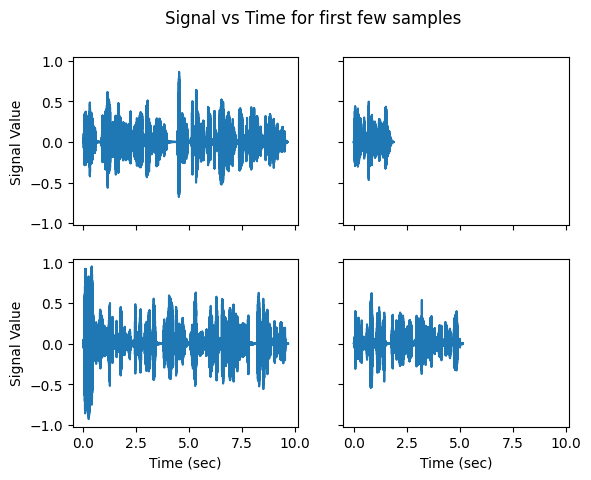

In [13]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
fig.suptitle(f"Signal vs Time for first few samples")

idx = 0
for i in range(2):
    for j in range(2):
        audio_sample = train_ds[idx]['audio']
        text_sample = train_ds[idx]['text']
        num_values = len(audio_sample['array'])
        sample_rate = audio_sample['sampling_rate']
        total_time = num_values/sample_rate
        x_time = np.linspace(0, total_time, num=num_values)
        y_amplitude = audio_sample['array']
        axs[i,j].plot(x_time, y_amplitude)
        idx += 1
for ax in axs.flat:
    ax.set(xlabel='Time (sec)', ylabel='Signal Value')
    ax.label_outer()


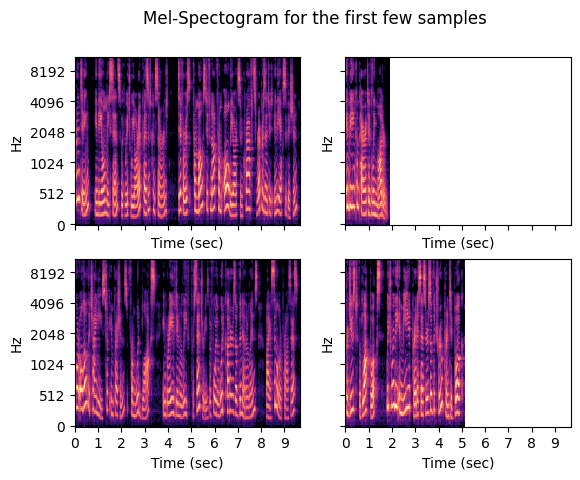

In [14]:
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.display import specshow

fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
fig.suptitle(f"Mel-Spectogram for the first few samples")
# fig.colorbar(label='Decibels')
idx = 0
for i in range(2):
    for j in range(2):
        audio_sample = train_ds[idx]['audio']
        sample_rate = audio_sample['sampling_rate']
        mel_spectrogram = melspectrogram(y=audio_sample['array'], sr=sample_rate)
        # Convert to decibels
        mel_spectrogram_db = power_to_db(mel_spectrogram, ref=np.max)
        specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sample_rate, ax=axs[i,j])
        idx += 1

for ax in axs.flat:
    ax.set(xlabel='Time (sec)', ylabel='Hz')



Original Text: Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition

Original Audio:



Testing with num_mels=32


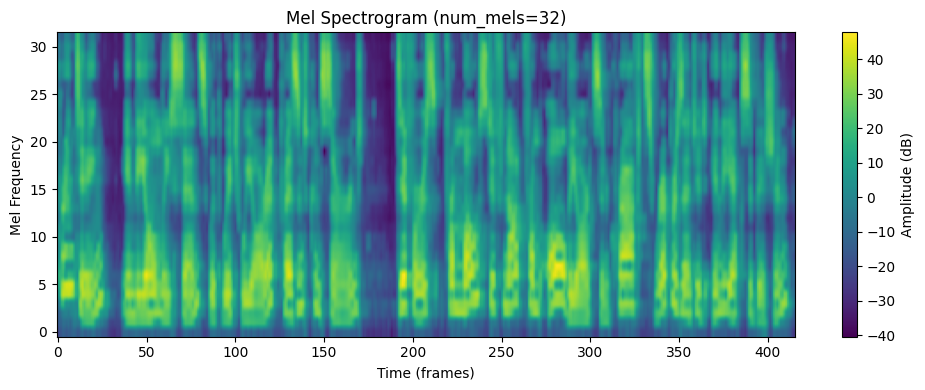

Reconstructing audio from STFT (not Mel Spectrogram):



Testing with num_mels=48


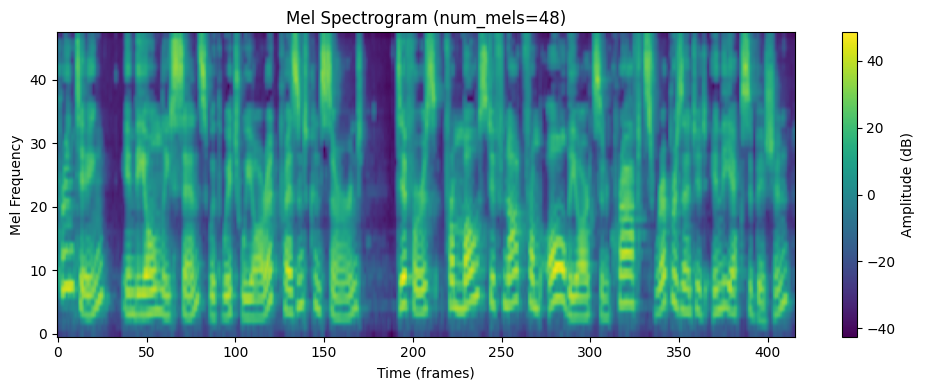

Reconstructing audio from STFT (not Mel Spectrogram):



Testing with num_mels=64


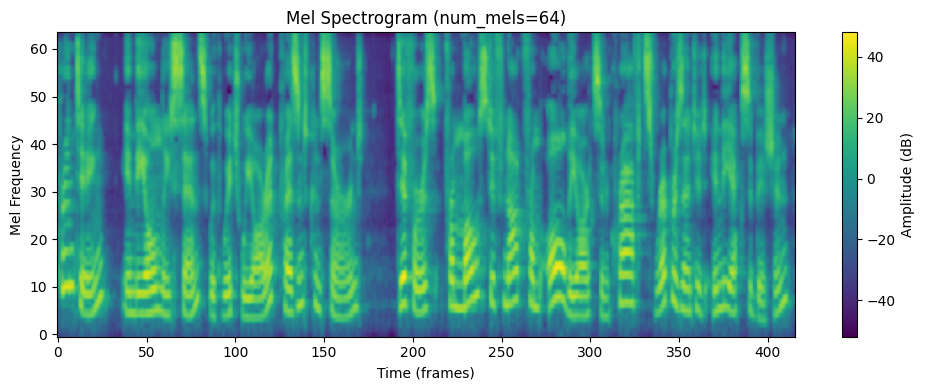

Reconstructing audio from STFT (not Mel Spectrogram):



Testing with num_mels=96


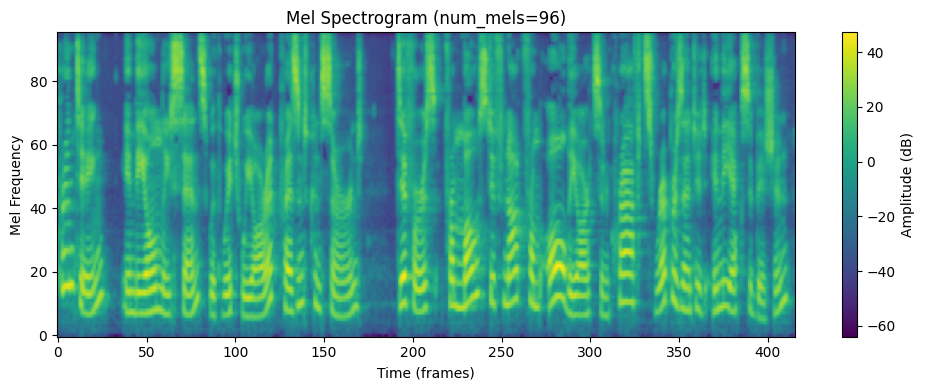

Reconstructing audio from STFT (not Mel Spectrogram):



Testing with num_mels=102


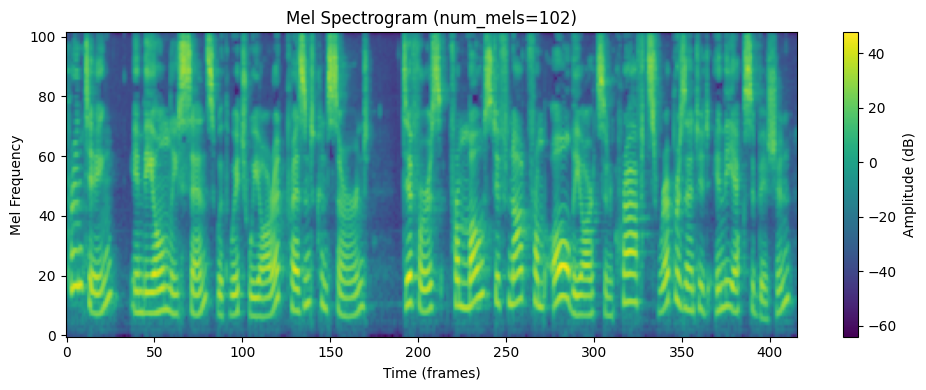

Reconstructing audio from STFT (not Mel Spectrogram):



Testing with num_mels=128


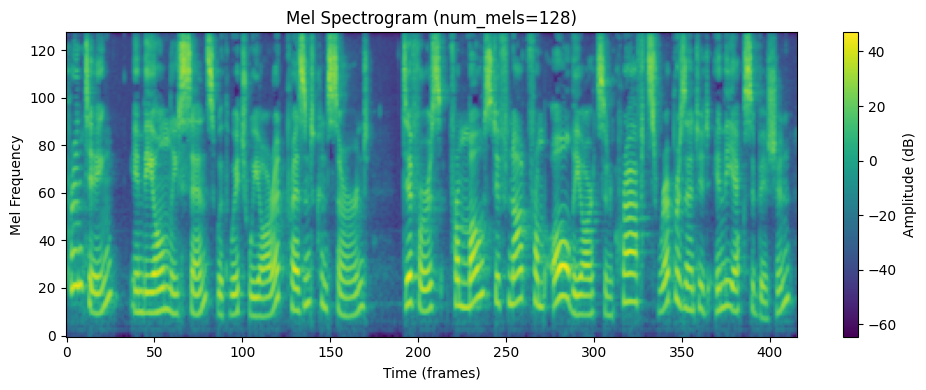

Reconstructing audio from STFT (not Mel Spectrogram):


In [15]:
mel_bins_to_test = [32, 48, 64, 96, 102, 128]

for i in range(1):
    audio_sample = train_ds[i]['audio']
    text_sample = train_ds[i]['text']
    print("Original Text:", text_sample)
    y = torch.tensor(audio_sample['array'], dtype=torch.float32)
    sr = audio_sample['sampling_rate']
    print("\nOriginal Audio:")
    display(Audio(data=y.numpy(), rate=sr))

    for num_mels in mel_bins_to_test:
        print(f"\nTesting with num_mels={num_mels}")
        mel_transform = T.MelSpectrogram(
            sample_rate=sr,
            n_mels=num_mels,
            n_fft=2048,
            hop_length=512,
            f_max=sr // 2
        )
        mel_spec = mel_transform(y)
        mel_spec_db = T.AmplitudeToDB()(mel_spec)

        # Plot Mel spectrogram
        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spec_db.numpy(), aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Mel Spectrogram (num_mels={num_mels})")
        plt.xlabel("Time (frames)")
        plt.ylabel("Mel Frequency")
        plt.colorbar(label="Amplitude (dB)")
        plt.tight_layout()
        plt.show()
        print("Reconstructing audio from STFT (not Mel Spectrogram):")
        stft_transform = T.Spectrogram(n_fft=2048, hop_length=512)
        spectrogram = stft_transform(y)

        griffin_lim = T.GriffinLim(n_fft=2048, hop_length=512)
        approx_audio = griffin_lim(spectrogram)

        # Play reconstructed audio
        display(Audio(data=approx_audio.numpy(), rate=sr))